# Market Basket Analysis for BreadBasket

In [94]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import mlxtend as ml

### Importing the Dataset

As said from the site:

Data set containing 15.010 observations and more than 6.000 transactions from a bakery. The data set contains the following columns:

- Date. Categorical variable that tells us the date of the transactions (YYYY-MM-DD format). The column includes dates from 30/10/2016 to 9/4/2017.

- Time. Categorical variable that tells us the time of the transactions (HH:MM:SS format).

- Transaction. Quantitative variable that allows us to differentiate the transactions. The rows that share the same value in this field belong to the same transaction, that's why the data set has less transactions than observations.

- Item. Categorical variable with the products.

In [76]:
bread = pd.read_csv(r"D:\Downloads\BreadBasket_DMS.csv")
bread.head(8)

,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam
5,2016-10-30,10:07:57,3,Cookies
6,2016-10-30,10:08:41,4,Muffin
7,2016-10-30,10:13:03,5,Coffee


In [97]:
df_head = bread.head()
table = ff.create_table(df_head)
py.iplot(table, filename='dataframe_ex_preview')

In [99]:
grid = Grid([Column(df_head[column_name], column_name) for column_name in df_head.columns])
url = py.grid_ops.upload(grid, filename='dataframe_ex_'+str(dt.now()), world_readable=True, auto_open=True)
print(url)

https://plot.ly/~GeorgeWong/23/


### EDA below

The code belows shows the top 10 items sold at BreadBasket. I guess everyone loves to drink coffee! 

In [101]:
bread['Item'].value_counts().iloc[:10]

Coffee           5471
Bread            3325
Tea              1435
Cake             1025
Pastry            856
NONE              786
Sandwich          771
Medialuna         616
Hot chocolate     590
Cookies           540
Name: Item, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

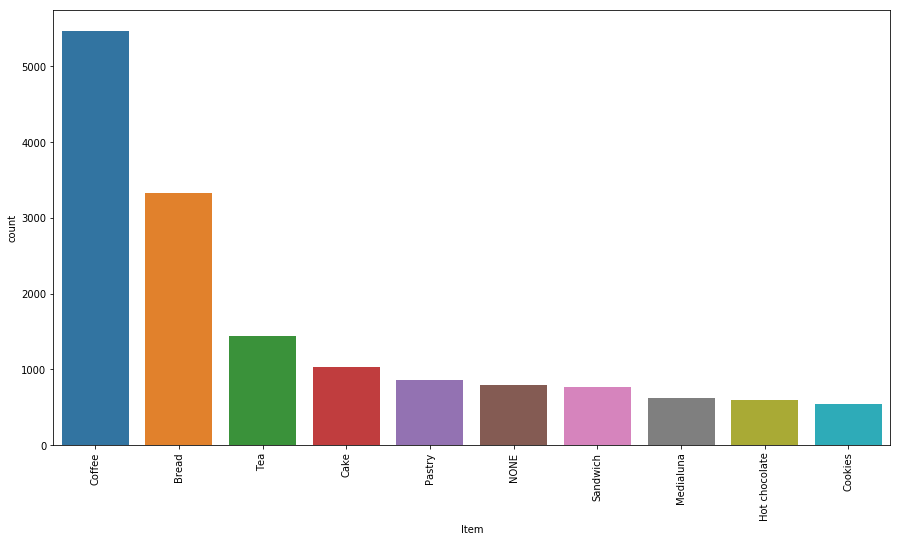

In [92]:
fig = plt.figure(figsize=(15,8))
sns.countplot(x = 'Item', data = bread, order = bread['Item'].value_counts().iloc[:10].index)
plt.xticks(rotation=90)

In [102]:
data = [go.Bar(y=bread['Item'].value_counts().iloc[:10], x = bread['Item'].value_counts().iloc[:10], marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6
              )]

py.iplot(data, filename='bar-direct-labels')

In [34]:
df = bread.groupby(['Transaction','Item']).size().reset_index(name='count')

In [35]:
df.head()

,Transaction,Item,count
0,1,Bread,1
1,2,Scandinavian,2
2,3,Cookies,1
3,3,Hot chocolate,1
4,3,Jam,1


In [63]:
timeseries = bread.groupby(['Date']).size().reset_index(name='count')

In [64]:
timeseries.head()

,Date,count
0,2016-10-30,180
1,2016-10-31,205
2,2016-11-01,154
3,2016-11-02,169
4,2016-11-03,195


#### Time Series

Time series for items sold thoughout the period

In [65]:
data = [go.Scatter( x= timeseries.Date, y=timeseries['count'])]
py.iplot(data)

In [41]:
df = bread.groupby(['Transaction','Item']).size().reset_index(name='count')
basket = (df.groupby(['Transaction', 'Item'])['count']
          .sum().unstack().reset_index().fillna(0)
          .set_index('Transaction'))

In [42]:
basket.head()

Item,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)

In [48]:
basket_sets = basket.applymap(encode_units)
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift")
rules.sort_values('confidence', ascending = False, inplace = True)
rules.head(10)

In [49]:
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
45,(Toast),(Coffee),0.033365,0.475081,0.023502,0.704403,1.482699,0.007651,1.775789
43,(Spanish Brunch),(Coffee),0.018046,0.475081,0.010807,0.598837,1.260494,0.002233,1.308493
28,(Medialuna),(Coffee),0.061379,0.475081,0.034939,0.569231,1.198175,0.005779,1.218561
34,(Pastry),(Coffee),0.085510,0.475081,0.047214,0.552147,1.162216,0.006590,1.172079
2,(Alfajores),(Coffee),0.036093,0.475081,0.019515,0.540698,1.138116,0.002368,1.142861
26,(Juice),(Coffee),0.038296,0.475081,0.020460,0.534247,1.124537,0.002266,1.127031
32,(NONE),(Coffee),0.079005,0.475081,0.042073,0.532537,1.120938,0.004539,1.122908
37,(Sandwich),(Coffee),0.071346,0.475081,0.037981,0.532353,1.120551,0.004086,1.122468
17,(Cake),(Coffee),0.103137,0.475081,0.054349,0.526958,1.109196,0.005350,1.109667
39,(Scone),(Coffee),0.034309,0.475081,0.017941,0.522936,1.100729,0.001642,1.100310
